# Recognition Using HOG Pipeline


## Importing Libraries

In [17]:
import cv2
import numpy as np
import pandas as  pd
import matplotlib.pyplot as plt
import random
import glob
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure

## Define a Function to Get The Ground Truth Contours

In [18]:
def get_gt_contours(i):
    gt_contours = []
    boxes = digitStruct.loc[f'{str(i)}.png', 'boxes']
    for box in boxes:
        x = box['left']
        y = box['top']
        w = box['width']
        h = box['height']
        label = int(box['label'])
        gt_contours.append([x, y, x+w, y+h,label])
    return gt_contours

## Reading Templates

In [19]:
new_templates = []
for i in range(2,92):
    tmp = cv2.imread(f'NEW_NUMBERS/{i}.jpg')
    gray = cv2.cvtColor(tmp, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
    new_templates.append(thresh)
for row in range(1,11):
    for col in range(1,11):
        template = cv2.imread(f"Templates/numbers/PineTools.com_2023-05-08_07h18m28s/PineTools.com_files/row-{row}-column-{col}.png")
        gray = cv2.cvtColor(template,cv2.COLOR_BGR2GRAY)
        thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
        new_templates.append(thresh)
        
for row in [1,2,3,4,6]:
    for col in range(0,10):
        template = cv2.imread(f"Templates/numbers/templates/row-{row}-column-{col}.png")
        gray = cv2.cvtColor(template,cv2.COLOR_BGR2GRAY)
        thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
        new_templates.append(thresh)

## Showing Templates Example

240


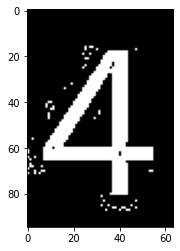

In [20]:
plt.imshow(new_templates[4],cmap = 'gray')
print(len(new_templates))

## Reading Image

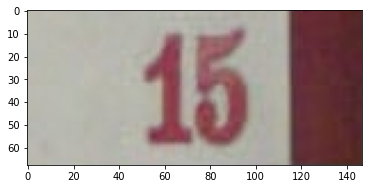

In [21]:
# i=random.randint(1,32402)
i=745
img = cv2.imread(f'data/train/{i}.png')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img2 = img.copy()
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(img,cmap='gray')

## Converting To Grayscale

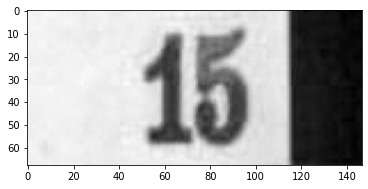

In [22]:
plt.imshow(img_gray,cmap='gray')

## Defining HOG Descriptor

In [23]:
win_size = (20, 20)   
block_size = (10, 10) 
block_stride = (5, 5) 
cell_size = (5, 5)    
nbins = 9             
hogCV = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)

## Reading DigitStruct File

In [24]:
digitStruct = pd.read_json('data/train/digitStruct.json')
digitStruct.set_index('filename', inplace=True)
digitStruct.head()

,boxes
filename,
1.png,"[{'height': 219.0, 'label': 1.0, 'left': 246.0..."
2.png,"[{'height': 32.0, 'label': 2.0, 'left': 77.0, ..."
3.png,"[{'height': 15.0, 'label': 2.0, 'left': 17.0, ..."
4.png,"[{'height': 34.0, 'label': 9.0, 'left': 57.0, ..."
5.png,"[{'height': 46.0, 'label': 3.0, 'left': 52.0, ..."


## Getting Ground Truth Contours

In [25]:
gt_contours = get_gt_contours(i)
print(len(gt_contours))
gt_contours

2


[[49.0, 8.0, 71.0, 65.0, 1], [67.0, 7.0, 101.0, 64.0, 5]]

## Plotting Ground Truth Contours

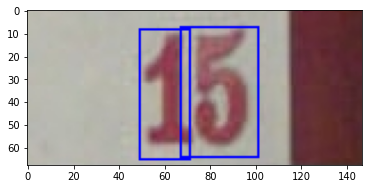

In [28]:
gt_boxes = img.copy()
for contour in gt_contours:
    contour = list(map(int, contour)) # To cast all point values to integers (loaded from json file as float)
    [x1, y1, x2, y2,label] = contour
    cv2.rectangle(gt_boxes, (x1,y1), (x2,y2), (0,0,255), 1)
plt.imshow(gt_boxes)

In [11]:
gt_contours = [list(map(int,contour)) for contour in gt_contours]
gt_contours

[[49, 8, 71, 65, 1], [67, 7, 101, 64, 5]]

## Recognizing Digits

1
5


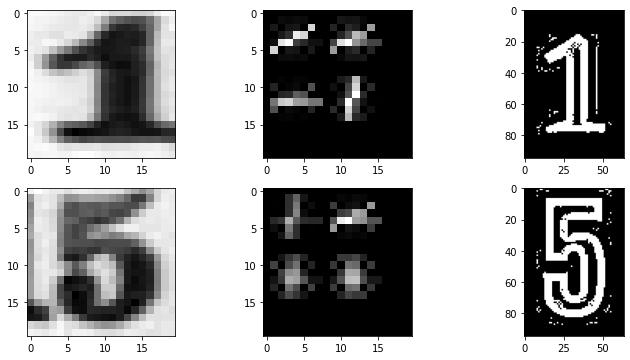

In [14]:
f, axarr = plt.subplots(len(gt_contours),3, figsize=(12, 6))
for k,contour in enumerate(gt_contours):
    score=0
    [x1, y1, x2, y2,label] = contour
    digit = img_gray[y1:y2,x1:x2]
#     plt.figure()
    
    digit_resized = cv2.resize(digit, win_size)
    fd, hog_image = hog(digit_resized, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True)
    axarr[k,1].imshow(hog_image, cmap="gray")
#     plt.figure()
    axarr[k,0].imshow(digit_resized,cmap = 'gray')
    digit_hog = hogCV.compute(digit_resized).reshape(-1)
    scores = []
    for i,template in enumerate(new_templates):
        template_resized = cv2.resize(template, win_size)
        template_hog = hogCV.compute(template_resized).reshape(-1)
        score = np.dot(digit_hog, template_hog)
        scores.append(score)
    tmp = scores.index(max(scores))
#     plt.figure()
    axarr[k,2].imshow(new_templates[tmp],cmap = 'gray')
    if tmp%10 == label:
        cv2.rectangle(img2, (x1,y1), (x2,y2), (0,255,0), 1)
        cv2.putText(img2,str(tmp%10), (x1, y1-1), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 1)
    
    print(tmp%10)

## Plotting Recognized Digits

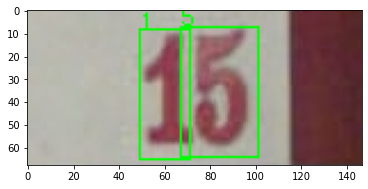

In [15]:
plt.imshow(img2,cmap='gray')